In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import tensorly
import matplotlib.ticker as ticker
import tensorsketch
from tensorsketch.tensor_approx import TensorApprox
import warnings
warnings.filterwarnings('ignore')

Using numpy backend.
Using numpy backend.


In [10]:
'''
The dataset can be downloaded from:
PSL(sea level pressure): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.PSL/file.html
BURDENDUST(Dust aerosol burden): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.BURDENDUST.html
CLOUD(cloud fraction): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.CLOUD/file.html
AODABS(Aerosol absorption optical depth 550 nm): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.AODABS/file.html
ABSORB(Aerosol absorption): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.ABSORB/file.html
SRFRAD(Net radiative flux at surface): https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CESM_CAM5_BGC_LE.atm.proc.monthly_ave.SRFRAD/file.html
'''
#CLOUD = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.013.cam.h0.CLOUD.208101-210012.nc").variables['CLOUD'][:]
AODABS = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.AODABS.040001-049912.nc").variables['AODABS'][:] 
AODABS = AODABS.filled(AODABS.mean())
ABSORB = nc.Dataset("data/b.e11.BRCP85C5CNBDRD.f09_g16.023.cam.h0.ABSORB.208101-210012.nc").variables['ABSORB'][:]
ABSORB = ABSORB.filled(ABSORB.mean())
SRFRAD = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.SRFRAD.040001-049912.nc").variables['SRFRAD'][:]
BURDENDUST = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.BURDENDUST.040001-049912.nc").variables['BURDENDUST'][:] 
#PSL = nc.Dataset("data/b.e11.B1850C5CN.f09_g16.005.cam.h0.PSL.200001-209912.nc").variables['PSL'][:]

KeyboardInterrupt: 

In [11]:
MARKER_LIST = ["s", "x", "o","+","*","d","^"]
def find_rm_label(rm_typ): 
    if rm_typ == "g": 
        return "Gaussian"
    elif rm_typ == "u":
        return "Uniform"
    elif rm_typ == "sp0":
        return "Sparse"
    elif rm_typ == "gprod":
        return "Gaussian Khatri-Rao"
    elif rm_typ == "ssrft":
        return "SSRFT"
def find_gen_label(gen_typ): 
    if gen_typ == "id": 
        return "Superdiagonal"
    elif gen_typ == "lk":
        return "Low Rank"
    elif gen_typ == "fed":
        return "Fast Exponential Decay"
    elif gen_typ == "sed": 
        return "Slow Exponential Decay"
    elif gen_typ == "fpd": 
        return "Fast Polynomial Decay"
    elif gen_typ == "spd": 
        return "Slow Polynomial Decay"

In [12]:
def simrun_name(name, inv_factor,rm_typ): 
    ''' 
    Create an file name for a simulation run
    '''
    return "data/"+name+"_frk"+str(inv_factor)+"_"+rm_typ+".pickle"
def simplot_name(name, inv_factor): 
    return "plots/"+name+"_frk"+str(inv_factor)+".pdf" 
    '''
    Create an file name for simulation result plots 
    ''' 

In [13]:
def multisimplotlog_name(name, inv_factor): 
    return "plots/aistats/"+"multi_"+name+"_frk"+str(inv_factor)+"log.pdf" 
def multiplot_realdata_frklog(rm_typs , data, inv_factor, name, fontsize = 18): 
    ranks = (np.array(data.shape)/inv_factor).astype(int)    
    kratio = np.arange(2/inv_factor,2/5, (2/5 -1/inv_factor)/10)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))
    sim_list = []
    ymaxs = [] 
    
    for i,rm_typ in enumerate(rm_typs):        
        sim_list.append(pickle.load(open(simrun_name(name, inv_factor, rm_typ), "rb" )))
        two_pass_result = [np.log(sim_list[i][1][j]/sim_list[i][0][j]) for j in range(len(sim_list[i][0]))]
        one_pass_result = [np.log(sim_list[i][2][j]/sim_list[i][0][j]) for j in range(len(sim_list[i][0]))]
        plt.plot(kratio,one_pass_result, label = find_rm_label(rm_typ), markersize = 10, marker = MARKER_LIST[i],markeredgewidth=1, markerfacecolor='None') 
        alldata = np.concatenate([two_pass_result,one_pass_result])
        ymaxs.append(max(alldata)) 
    ymin = 0
    ymax = max(ymaxs)
    plt.legend(loc = 'best')
    plt.title("r/I = %s"%round(1/inv_factor,3))
    plt.xlabel('Compression Factor: $\delta_1$ = k/I')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig(multisimplotlog_name(name,inv_factor))
    plt.show()

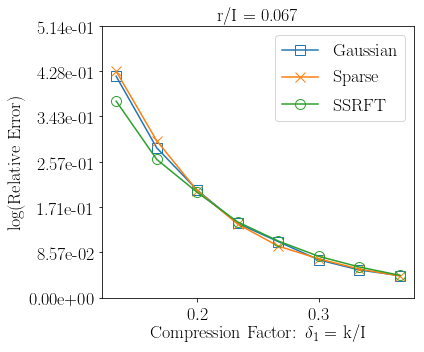

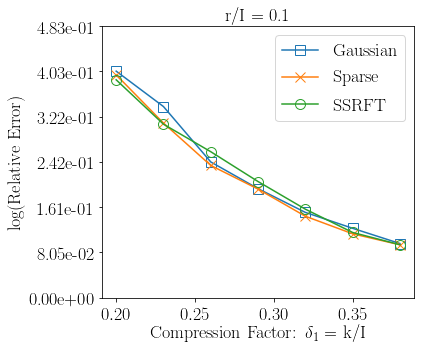

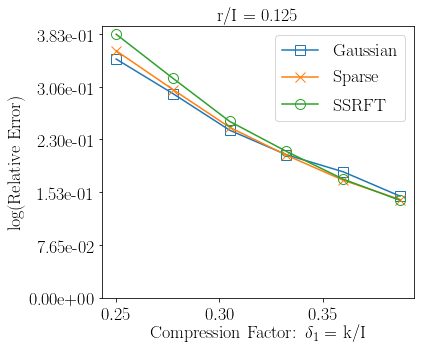

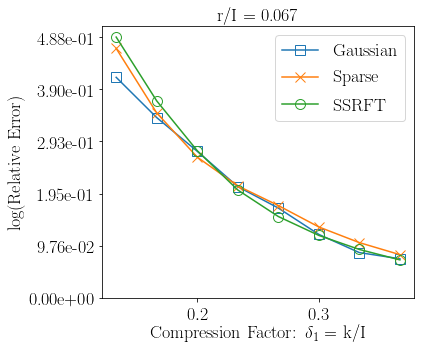

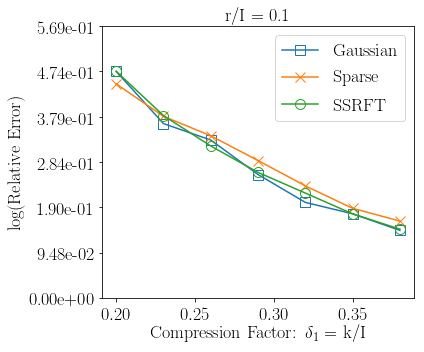

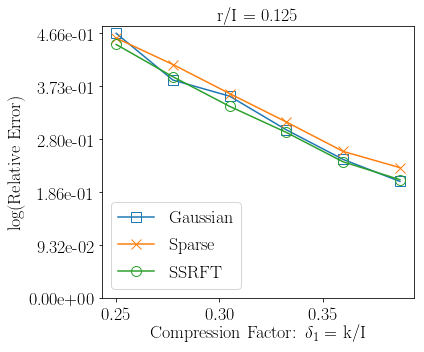

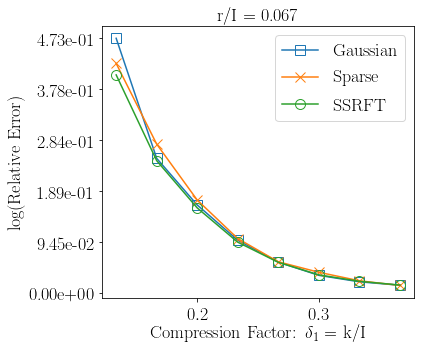

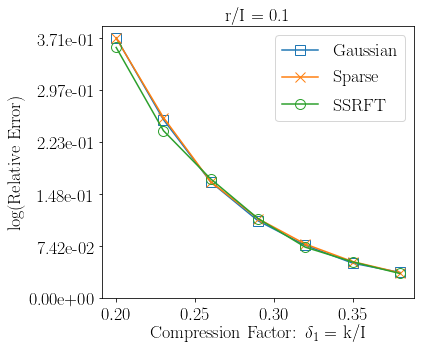

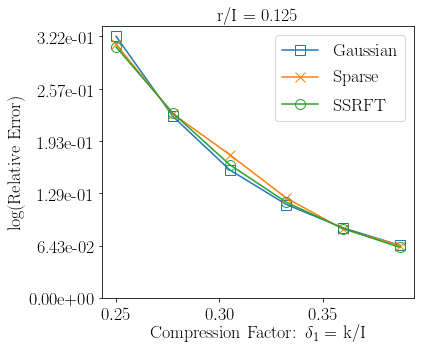

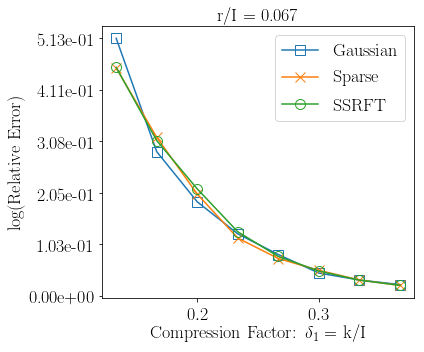

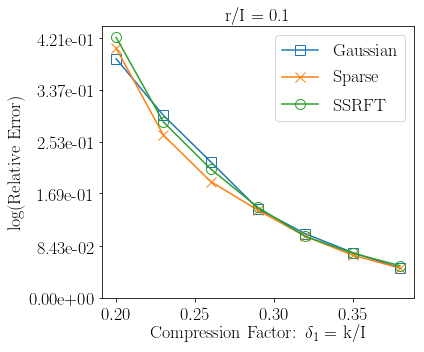

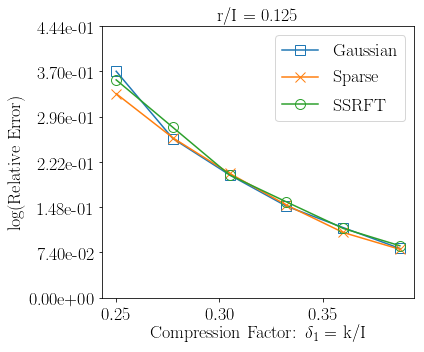

In [14]:
multiplot_realdata_frklog(['g','sp0','ssrft'], ABSORB,15,"ABSORB")
multiplot_realdata_frklog(['g','sp0','ssrft'], ABSORB,10,"ABSORB")
multiplot_realdata_frklog(['g','sp0','ssrft'], ABSORB,8,"ABSORB")
multiplot_realdata_frklog(['g','sp0','ssrft'], SRFRAD,15,"SRFRAD")
multiplot_realdata_frklog(['g','sp0','ssrft'], SRFRAD,10,"SRFRAD")
multiplot_realdata_frklog(['g','sp0','ssrft'], SRFRAD,8,"SRFRAD")
multiplot_realdata_frklog(['g','sp0','ssrft'], BURDENDUST,15,"BURDENDUST")
multiplot_realdata_frklog(['g','sp0','ssrft'], BURDENDUST,10,"BURDENDUST")
multiplot_realdata_frklog(['g','sp0','ssrft'], BURDENDUST,8,"BURDENDUST")
multiplot_realdata_frklog(['g','sp0','ssrft'], AODABS,15,"AODABS")
multiplot_realdata_frklog(['g','sp0','ssrft'], AODABS,10,"AODABS")
multiplot_realdata_frklog(['g','sp0','ssrft'], AODABS,8,"AODABS")

In [15]:
def multiplot_realdata_fk(rm_typs, data, name,title, random_seed = 1,fontsize = 18): 
    X = data 
    kratio = 1/5
    r0ratio = 1/20
    rratios = np.arange((r0ratio),(1/5),(1/100))
    dim = np.array(X.shape)
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)    
    plt.figure(figsize=(6,5))  
    ymins = [] 
    ymaxs = []
    sim_list = [] 
    for i,rm_typ in enumerate(rm_typs):
        sim_list.append(pickle.load(open("data/"+name+"_"+rm_typ+"_fk.pickle","rb")))      
        two_pass_result = [np.log(sim_list[i][0][j]/sim_list[i][2][j]) for j in range(len(sim_list[i][2]))]
        one_pass_result = [np.log(sim_list[i][1][j]/sim_list[i][2][j]) for j in range(len(sim_list[i][2]))]    
        plt.plot(rratios,one_pass_result, label = find_rm_label(rm_typ), markersize = 10, marker = MARKER_LIST[i],markeredgewidth=1, markerfacecolor='None') 
        alldata = np.concatenate([one_pass_result,two_pass_result])
        ymins.append(min(alldata))
        ymaxs.append(max(alldata))
    plt.legend(loc = 'best')
    plt.title(title)
    plt.xlabel('$r/I$')
    plt.ylabel('log(Relative Error)')
    plt.minorticks_off()
    ymin = min(ymins)
    ymax = max(ymaxs)
    def round_to_n(x,n): 
        if x == 0: 
            return 0
        else: 
            return round(x,-int(np.floor(np.log10(abs(x))))+n-1) 
    ticks = [round_to_n(i,3) for i in np.arange(ymin, ymax+(ymax-ymin)/5,(ymax-ymin)/5)] 
    plt.yticks(ticks)
    plt.axes().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e')) 
    plt.axes().xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)
    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.axhline(0, color='black',linewidth = 1)
    plt.tight_layout()
    plt.savefig("plots/aistats/"+"multi_"+name+"_fk.pdf")
    plt.show()
    

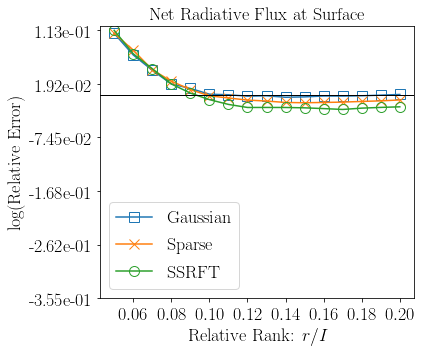

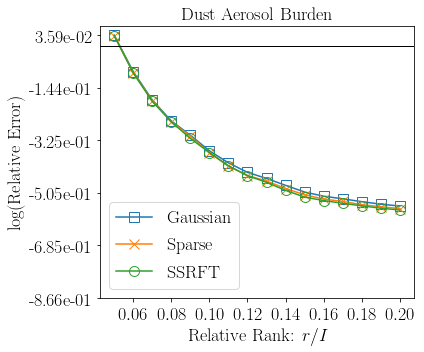

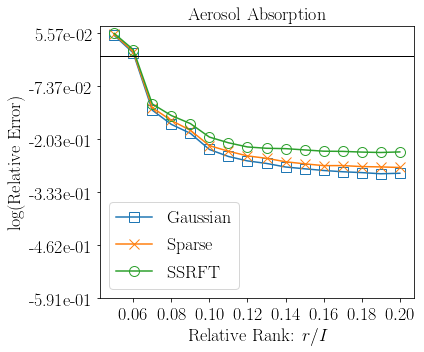

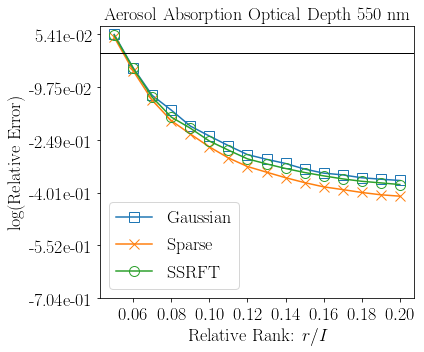

In [16]:
multiplot_realdata_fk(['g','sp0','ssrft'], SRFRAD,"SRFRAD", "Net Radiative Flux at Surface")
multiplot_realdata_fk(['g','sp0','ssrft'], BURDENDUST,"BURDENDUST", "Dust Aerosol Burden")
multiplot_realdata_fk(['g','sp0','ssrft'], ABSORB,"ABSORB", "Aerosol Absorption")
multiplot_realdata_fk(['g','sp0','ssrft'], AODABS,"AODABS", "Aerosol Absorption Optical Depth 550 nm")